In [48]:
import numpy as np
from qiskit import *
import qiskit.providers.aer.noise as noise

ibmqfactory.load_account:WARNING:2022-04-28 21:53:12,784: Credentials are already in use. The existing account in the session will be replaced.


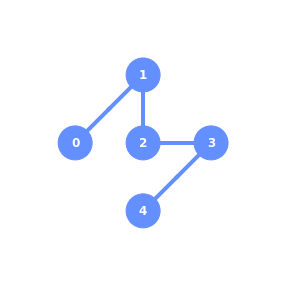

In [49]:
from qiskit.providers.ibmq import least_busy
from qiskit.visualization import plot_gate_map
from qiskit.tools.monitor import job_monitor
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
backend = least_busy(provider.backends(filters=lambda b: b.configuration().n_qubits >= 4 and
                                   not b.configuration().simulator and b.status().operational==True))
plot_gate_map(backend)

In [51]:
noise_model = noise.NoiseModel.from_backend(backend)

In [52]:
class Alice:
    def __init__(self, epsilon, no_of_children):
        self.epsilon = epsilon
        self.no_of_children = no_of_children
        self.measurements = list()
        self.__gen_bit_flip_index()
    
    def __gen_bit_flip_index(self):
        self.__index = 1 # np.random.randint(self.no_of_children) + 1
        
    def get_index(self)->int:
        return self.__index
        
    def measure(self, measurement: int)->None:
        self.measurements.append(measurement)
    
class Children:
    def __init__(self, epsilon):
        self.epsilon = epsilon
        self.flip = False
        self.bases = list()
        self.__measurements = list()
        
    def set_flip(self):
        self.flip = True
        
    def gen_measurement_basis(self, qc: QuantumCircuit, qr: int)->None:
        e = np.random.rand()
        if e <= self.epsilon:
            self.bases.append('X')
            qc.h(qr)
        else:
            self.bases.append('Z')
        qc.measure(qr, qr)
        
    def get_alice_measurements(self, alice_measurements)->None:
        self.alice_measurements = alice_measurements
        
    def get_all_bases(self, all_bases)->None:
        self.all_bases = all_bases 
        
    def gen_key(self):
        for i in range(len(self.alice_measurements)):
            if self.flip and self.alice_measurements[i] == 1:
                self.__measurements[i] = 1 - self.__measurements[i]
        idx_to_keep = list()
        for i in range(len(self.bases)):
            keep = True
            for bases in self.all_bases:
                if bases[i] == 'X':
                    keep = False
                    break
            if keep:
                idx_to_keep.append(i)
        self.__key = [self.__measurements[idx] for idx in idx_to_keep]
            
    def measure(self, measurement: int)->None:
        self.__measurements.append(measurement)
        
    def get_key(self):
        return self.__key
    
    def get_measurememts(self):
        return self.__measurements

In [53]:
class CommonSpace:
    def __init__(self, no_of_children = 2, no_of_measurements = 1024):
        epsilon = 0.1
        self.no_of_children = no_of_children
        self.no_of_measurements = no_of_measurements
        self.alice = Alice(epsilon, self.no_of_children)
        self.children = [Children(epsilon) for _ in range(self.no_of_children)]
        self.qc = list()
        
    def gen_entanglement(self)->QuantumCircuit:
        qc = QuantumCircuit(self.no_of_children + 1, self.no_of_children + 1)
        qc.h(0)
        qc.h(1)
        for i in range(1, self.no_of_children):
            qc.cx(i, i + 1)
        idx = self.alice.get_index()
        qc.cx(0, idx)
        qc.barrier()
        return qc
    
    def measurement_phase(self):
        for _ in range(self.no_of_measurements):
            qc = self.gen_entanglement()
            qc.measure(0, 0)
            self.__set_bases(qc)
            self.qc.append(qc)
            aer_sim = Aer.get_backend('aer_simulator')
            result = execute(qc, aer_sim, shots = 1, noise_model = noise_model)
            
            self.alice.measure(int(list(result.result().get_counts().keys())[0][-1]))
            for i in range(self.no_of_children):
                self.children[i].measure(int(list(result.result().get_counts().keys())[0][-2 - i]))
                
    def agreement_phase(self):
        all_bases = list()
        for child in self.children:
            child.get_alice_measurements(self.alice.measurements)
            all_bases.append(child.bases)
        self.children[self.alice.get_index() - 1].set_flip()
        for child in self.children:
            child.get_all_bases(all_bases)
            child.gen_key()
            
    def __set_bases(self, qc: QuantumCircuit)->None:
        for i in range(self.no_of_children):
            self.children[i].gen_measurement_basis(qc, i + 1)

In [57]:
cs = CommonSpace(no_of_children = 3, no_of_measurements = 16)
cs.measurement_phase()
cs.agreement_phase()

In [58]:
print(len(cs.children[0].get_key()))
key_len = len(cs.children[0].get_key())
keys = list()
for i in range(3):
    print(cs.children[i].get_key())
    keys.append(cs.children[i].get_key())

err_count = 0
for i in range(key_len):
    if keys[0][i] != keys[1][i] or keys[1][i] != keys[2][i]:
        err_count += 1
        
print(f"Error Ratio: {err_count/key_len}")

8
[0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 1, 0, 0, 0, 0]
[0, 0, 0, 1, 0, 1, 0, 0]
Error Ratio: 0.25
